# Solution

In [191]:
# put all python import statements here
from NumericalComputationCW.solvers import solver
from NumericalComputationCW.solvers import y_type
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple, TypeVar

## Implementation

The fireworks' trajectory can be modelled by the following differential equations:
### $\frac{d}{dt}y(t)=v(t)$
### $\frac{d}{dt}v(t)=\frac{-k(v(t))^2-g}{m}$
where $m$ is the mass of the firework, $g$ is acceleration due to gravity and $k$ determines air resistance on the firework.\
The equations are also subject to the initial conditions $y(t=0)=0, v(t=0)=a$ and a time step and stopping time of ($\mathrm{d}t$, $T$).

We can use the company solvers with parameters of $m=1,g=10,k=0.1,y(t=0)=0$ and $v(t=0)=15$ to simulate to $T=1$.


In [192]:
def fireworkSolver(k: np.double, g: np.double, m: np.double, y0: np.double, v0: np.double, t0: np.double, dt: np.double, T: np.double, method: str):
    """
    Uses the company solver with parameters to solve the differential equations.

    Args:
        k (np.double): air resistance coefficient
        g (np.double): acceleration due to gravity
        m (np.double): mass 
        y0 (np.double): displacement when t = t0
        v0 (np.double): velocity when t = t0
        t0 (np.double): starting time
        dt (np.double): time step
        T (np.double): ending time
        method (str): choose between "Van der Houwen", "Ralston' and 'Runge-Kutta'
    Returns:
        Tuple[List[np.double], List[y_type]]: t, y
    """

    def rhs(t: np.double, y: np.ndarray):
        # y[0] = solution for dy/dt
        # y[1] = solution for dv/dt
        
        return np.array([
            y[1], 
            (-k * y[1]**2 * np.sign(y[1]) - g)/m  
        ])

    t, y = solver(rhs, np.array([y0, v0]), t0, dt, T, method)
    
    return t, y
   


The three methods chosen to solve this equation are the classic Runge-Kutta, Van der Houwen and Ralston method. Using solvers, each of which is a different order, allows us to compare results between methods that differ in how they prioritise computational cost and accuracy of results.


In [193]:
def find_starting_points(k: np.double, g: np.double, m: np.double, y0: np.double, t0: np.double, dt: np.double, T: np.double, H: np.double, method: str, step: np.double):
    """
    Finds 2 points that encompass the root of F(a)    

    Args:
        k (np.double): air resistance coefficient
        g (np.double): acceleration due to gravity
        m (np.double): mass 
        y0 (np.double): displacement when t = t0
        t0 (np.double): starting time
        dt (np.double): time step
        T (np.double): ending time
        H (np.double): desired height to be reached when t = T
        method (str): choose between 'Van der Houwen', 'Ralston' and 'Runge-Kutta'
        step (np.double): interval between boundary values

    Returns:
        a1 (np.double), a2 (np.double): boundary values for the roots range
    """
    
    #  Find the points where F(a1)F(a2) < 0
    #   - Finds a point where y(T) > H, when , when v(t=0)=a2, 
    #     hence when v(t=0) = a2-step = a1, y(T) < H, 
    #     which means the F(a*) = 0 is a1 < a_root < a2.
    
    # Initialises a2 to step
    a2 = np.double(0.1)
    
    # Solves differential equation to find y(T) when v(t=0) = a2
    t, y = fireworkSolver(k=k, g=g, m=m, y0=y0, v0=a2, t0=t0, dt=dt, T=T, method=method)
    y_at_T = y[-1][0] - H
    
    # Solves differential with increasing a2, until firework trajectory passes 0
    while y_at_T < 0:
        a2 += step
        t, y = fireworkSolver(k=k, g=g, m=m, y0=y0, v0=a2, t0=t0, dt=dt, T=T, method=method)
        y_at_T = y[-1][0] - H
        
    # Returns root range
    return a2 - step, a2

In [194]:
def bisection(k: np.double, g: np.double, m: np.double, y0: np.double, t0: np.double, dt: np.double, T: np.double, H: np.double, method: str, step: np.double, tolerance: np.double):
    """
    Uses bisection method to find a value of v(t=0) = a, where the firework will explode
    at height H after time T.    

    Args:
        k (np.double): air resistance coefficient
        g (np.double): acceleration due to gravity
        m (np.double): mass 
        y0 (np.double): displacement when t = t0
        t0 (np.double): starting time
        dt (np.double): time step
        T (np.double): ending time
        H (np.double): desired height to be reached when t = T
        method (str): choose between 'Van der Houwen', 'Ralston' and 'Runge-Kutta'
        step (np.double): interval between boundary values
        tolerance (np.double): tolerance level for boundary values
        
    Returns:
        np.double: value of a when F(a) = 0
    """
    
    #  1) Find suitable a1 and a2.
    a1, a2 = find_starting_points(k=k, g=g, m=m, y0=y0, t0=t0, dt=dt, T=T, H=H, method=method, step=step)
    
    #  2) Reduce the range until a2 - a1 is lower than the predifined tolerance level
    #     - Once the range is sufficiently small, return the midpoint as a_root
    #     - This is the root of the equation F(a) = 0, where F(a) = y(T) - H
    
    while True:
        # Potential root set as midpoint of range
        a = np.double((a1 + a2) / 2)
        
        # Solves differential for midpoint
        t, y_a = fireworkSolver(k=k, g=g, m=m, y0=y0, v0=a, t0=t0, dt=dt, T=T, method=method)
        
        # Extracts the solution at time T 
        y_a_at_T = y_a[-1][0] - H
        
        # Adjusts boundaries to narrow down the range 
        if y_a_at_T == 0:
            return a
        elif y_a_at_T < 0:
            a1 = a
        else:
            a2 = a
            
        if (a2 - a1) < tolerance:
            # Returns the root of the equation F(a) = 0, which is the midpoint of the range a1 and a2f
            return (a1 + a2) / 2    

In [195]:
def secant(k: np.double, g: np.double, m: np.double, y0: np.double, t0: np.double, dt: np.double, T: np.double, H: np.double, method: str, step: np.double, error_threshold: np.double):
    """
    Uses secant method to find a value of v(t=0) = a, where the firework will explode
    at height H after time T.    

    Args:
        k (np.double): air resistance coefficient
        g (np.double): acceleration due to gravity
        m (np.double): mass 
        y0 (np.double): displacement when t = t0
        t0 (np.double): starting time
        dt (np.double): time step
        T (np.double): ending time
        H (np.double): desired height to be reached when t = T
        method (str): choose between 'Van der Houwen', 'Ralston' and 'Runge-Kutta'
        step (np.double): interval between boundary values
        error_threshold (np.double): error_threshold to use as stopping point
    Returns:
        np.double: value of a when F(a) = 0
    """
    
    # 1) Find suitable starting values.
    a_p, a_c = find_starting_points(k=k, g=g, m=m, y0=y0, t0=t0, dt=dt, T=T, H=H, method=method, step=step)

    
    #  2) Use the formula a_n = a_c - y(a_c)(a_c - a_p)/(y(a_c) - y(a_p))
    #     - a_n is the next guess, a_c is the current guess, and a_p is the previous guess
    #     - Stop when relative error abs((a_n - a_c) / a_n) < error_threshold
    
    a_n = np.double(1)
    
    t,y = fireworkSolver(k=k, g=g, m=m, y0=y0, v0=a_c, t0=t0, dt=dt, T=T, method=method)
    y_a_c = y[-1][0] - H
    
    t, y = fireworkSolver(k=k, g=g, m=m, y0=y0, v0=a_p, t0=t0, dt=dt, T=T, method=method)
    y_a_p = y[-1][0] - H
    
    while True:
        a_n = a_c - (y_a_c * ((a_c - a_p)/(y_a_c - y_a_p)))
        
        relative_error = abs((a_n - a_c) / a_n)
        if relative_error < error_threshold:
            return a_n
        
        # Sets next iteration values
        y_a_p = y_a_c
        a_p = a_c
        a_c = a_n
        
        # Calculates y_a_n and stores it as y_a_c
        t, y = fireworkSolver(k=k, g=g, m=m, y0=y0, v0=a_n, t0=t0, dt=dt, T=T, method=method)
        y_a_c = y[-1][0] - H

## Results

The first test will be to plot the solutions to both differentials to check if we are getting reasonable trajectories for each of the chosen numerical methods. This is done for the parameter set: \
    $k=0.1, g=10, m=1, a=15, T=1$ \
for a range of: \
    $dt = T/50, T/100, T/150, T/200, T/400, T/600, T/800, T/1200, T/1600, T/2400, T/3200$.

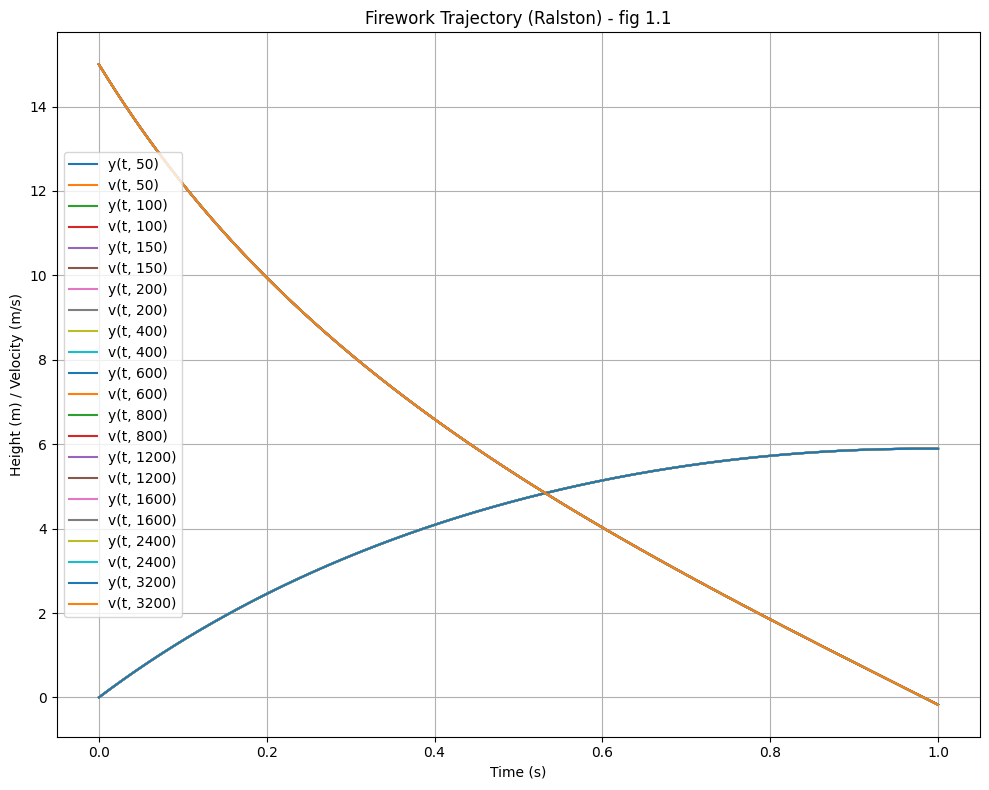

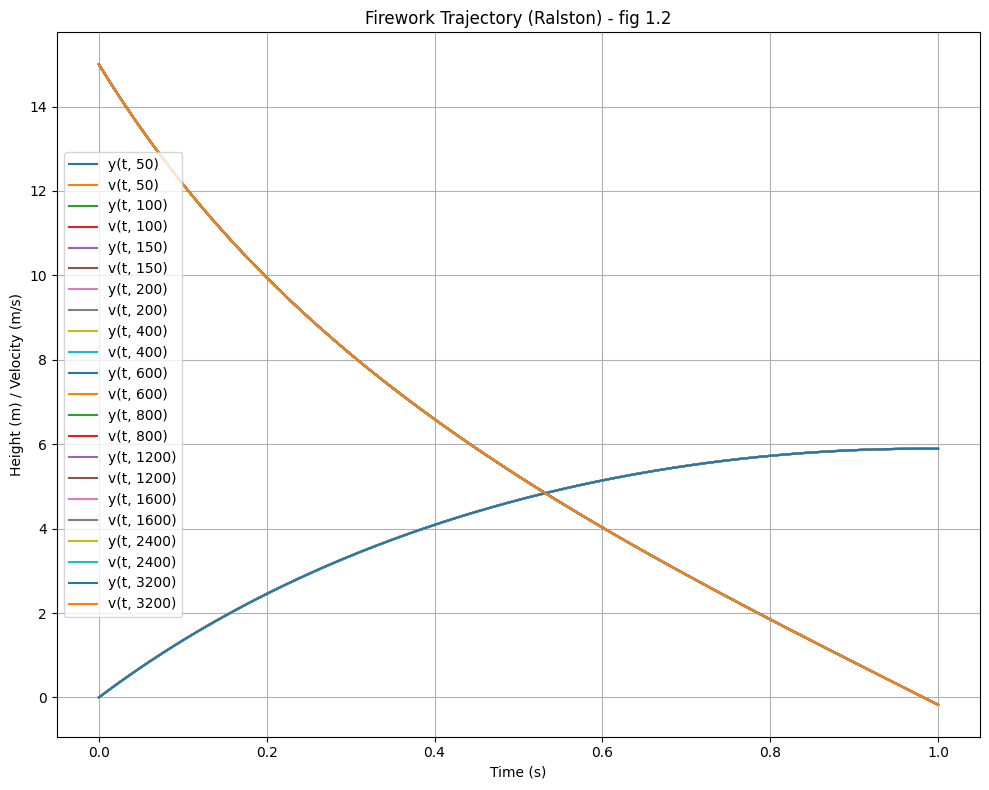

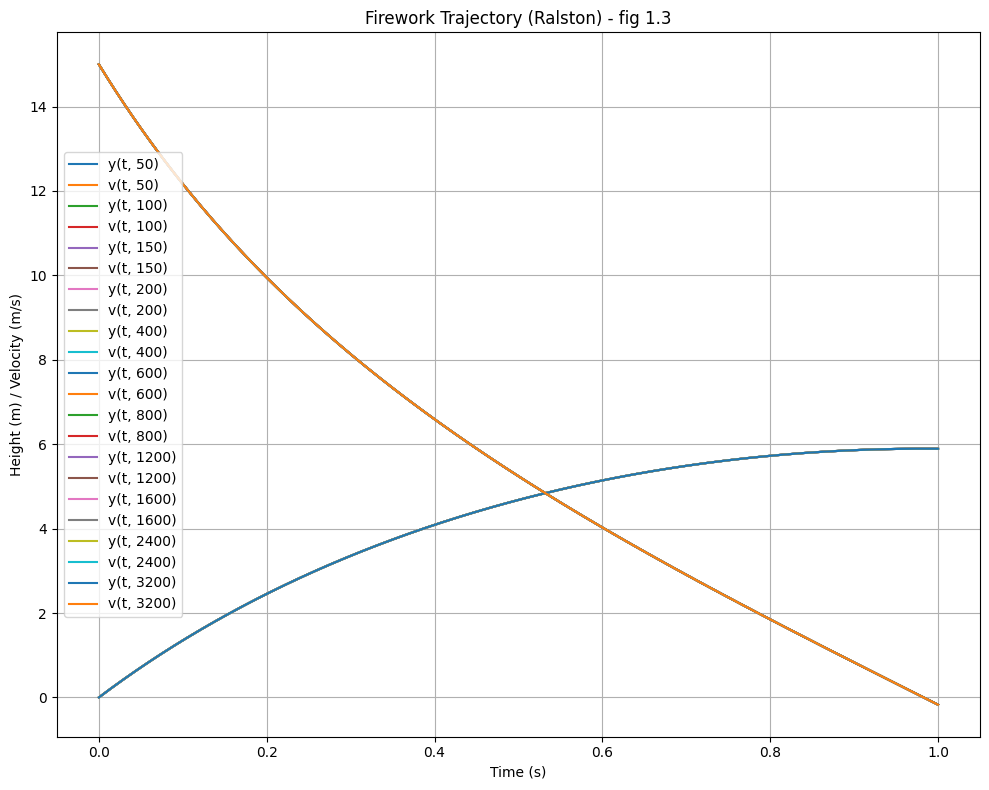

In [210]:
def plot_results(method, dt_set, index):
    plt.figure(figsize=(10, 8))
    for dt in dt_set:    
        t, y = fireworkSolver(k=0.1, g=10, m=1, y0=0, v0=15, t0=0, dt=1/dt, T=1, method=method)    
        
        plt.plot(t, [pos[0] for pos in y], label=f"y(t, {dt})")
        plt.plot(t, [pos[1] for pos in y], label=f"v(t, {dt})")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Height (m) / Velocity (m/s)")
    plt.title(f"Firework Trajectory ({method}) - fig 1.{index}")
    plt.grid()
    plt.legend()
    plt.tight_layout()

dt_set = [50, 100, 150, 200, 400, 600, 800, 1200, 1600, 2400, 3200]
for index, method in enumerate(["Ralston", "Van der Houwen", "Runge-Kutta"]):
    plot_results(method="Ralston", dt_set=dt_set,index=index+1)

plt.show()


Next we want to test the accuracy of the solution for each of the methods. We know that the exact solution for the parameter set, defined above, is $5(log(\frac{13}{4}) + 2 log(cos(1 −cos^{-1}(\frac{2}{√13})))) ≈5.891794628863073$, hence we can calculate the relative errors for each method for each $dt$. From this point on, almost all results will be show to 15 decimal places, as that is how many places the exact solution uses.

In [ ]:
def create_table(method, dt_set, actual_solution):
    """
    Creates a dataframe containing analytical data for each dt.

    Args:
        method (string): method for solver to use
        dt_set (int array): values of dt
        actual_solution (np.double): actual soloution for error calculation

    Returns:
        pd.DataFrame: dataframe containing analytical data for each dt.
    """
    
    # Initialises arrays to be added to dataframe
    results_array = []
    error_array = []
    time_taken_array = []
    dt_array = []
    
    for dt in dt_set:
        # Use to calculate average time.
        temp_array = []
        for i in range(0, 10):
            start = time.time()    
            t, y = fireworkSolver(k=0.1, g=10, m=1, y0=0, v0=15, t0=0, dt=1/dt, T=1, method=method)   
            end = time.time()
            temp_array.append(end-start)
         
        result = np.double(y[-1][0])
        relative_error = abs((actual_solution - result)/actual_solution)
        
        results_array.append(result)
        error_array.append(relative_error)
        time_taken_array.append(sum(temp_array)/10)
        dt_array.append(1/dt)
    
    # Creates a dataframe with the results for each dt
    df = pd.DataFrame({
        "dt": dt_set,
        "1/dt": dt_array,
        "result": results_array,
        "relative error": error_array,
        "time taken": time_taken_array
    })
    
    # Calculates error ratio between current and previous value.
    df['error_ratio'] = df['relative error'] / df['relative error'].shift()
    
    return df


def plot_results_differential_solver(method, dt_set, actual_solution, index):
    """
    Outputs the values in the dataframe using plt table, for better data
    visualisation.

    Args:
        method (string): method for solver to use
        dt_set (int array): values of dt
        actual_solution (np.double): actual soloution for error calculation

    Returns:
        plt.Figure: table of results
    """
    
    # Initialises dataframe and table
    df = create_table(method, dt_set, actual_solution)
    df_table, axes = plt.subplots(figsize=(20, 6))
    axes.axis("off") 
    
    # Creates rows to be added to the table
    row_data = []
    for i, row in df.iterrows():
        row_data.append([
            f'{row["dt"]:.0f}',
            f'{row["1/dt"]:.8f}',
            f'{row["result"]:.15f}',
            f'{row["relative error"]:.15e}',
            f'{row["time taken"]:.15f}',
            f'{row["error_ratio"]:.15f}' if not pd.isna(row["error_ratio"]) else 'N/A'
        ])
    
    # Sets column headings and centers all text
    table = axes.table(
        cellText=row_data,
        colLabels=["dt","1/dt", "Result", "Relative Error", "Average Time Taken (10 Readings)", "Error Ratio"],
        loc="center",
        cellLoc="center"
    )
    
    # Increases from the default font size
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    # Scales table, and sets a title
    table.scale(1, 2)
    plt.title(f"Results for {method} Method - fig 2.{index+1}")
    plt.tight_layout()
    
    return df_table


for index, method in enumerate(["Ralston", "Van der Houwen", "Runge-Kutta"]):
    table = plot_results_differential_solver(method=method, dt_set=[50, 100, 150, 200, 400, 600, 800, 1200, 1600, 2400, 3200], actual_solution=np.double(5.891794628863073), index=index)
    plt.show()

The bisection and secant methods will be used to compute a value for $a$ for when $F(a) = y(1.5;a) - 10 = 0$. Both these methods use a function, find_starting_points(), to find initial starting values, that uses a pre-defined step size to limit the range for the initial values. The tests below will therefore test for different step-sizes to see the effect it has on the computation speed for the non-linear equation, and will also test for different error thresholds for the secant method and tolerance levels for the bisection method. Note that the  values for both will be the same for each test case.

The first test will try to find the optimal value for step size, using an abritrary value of $1.0 * 10^{-8}$, for the error threshold and tolerance level. The following parameter set will be used:\
 $k=0.05, g=9.81, m=1.3, dt=T/100, T=1.5, H=10$\
 (Note: cell takes around 10 seconds to load - might be longer on slower devices).

In [ ]:
def create_table(step_set, method):
    """
    Creates a dataframe containing analytical data for each step size.

    Args:
        step_set (int array): values of step sizes
        method (string): method for solver to use

    Returns:
        pd.DataFrame: dataframe containing analytical data for each dt.
    """

    # Initialises arrays to be added to dataframe
    results_array = []
    time_taken_array = []
    
    for step in step_set:
        # Used to find average time taken
        temp_array = []
        
        for i in range(0, 10):
            if method == "Secant":
                start = time.time()
                result = secant(k=0.05, g=9.81, m=1.3, y0=0, t0=0, dt=1.5/100, T=1.5, H=10, method="Van der Houwen", step = np.double(step), error_threshold=0.00000001)
                end = time.time()
                
            elif method == "Bisection":
                start = time.time()
                result = bisection(k=0.05, g=9.81, m=1.3, y0=0, t0=0, dt=1.5/100, T=1.5, H=10, method="Van der Houwen", step = np.double(step), tolerance = 0.00000001)
                end = time.time()
            
            temp_array.append(end-start)
                
        results_array.append(result)
        time_taken_array.append(sum(temp_array)/10)
    
    # Creates a dataframe with the results for each step size
    df = pd.DataFrame({
        "step": step_set,
        "result": results_array,
        "time taken": time_taken_array
    })
    
    # Calculates result ratio between current and previous value.
    df["result_ratio"] = df["result"] / df["result"].shift()
    
    return df
    
    
def plot_results_non_linear_solver_step_sizes(step_set, method, index=index):
    """
    Outputs the values in the dataframe using plt table, for better data
    visualisation. Includes a line graph of time taken against step size.

    Args:
        step_set (int array): values of step sizes
        method (string): method for solver to use
        index (int): used to number the figure

    Returns:
        plt.Figure: table and line graph of results
    """
    
    df = create_table(step_set, method)
    
    # Creates rows to add to the table.
    row_data = []
    for i, row in df.iterrows():
        row_data.append([
            f'{row["step"]:.2f}',
            f'{row["result"]:.15f}',
            f'{row["time taken"]:.15f}',
            f'{row["result_ratio"]:.15f}' if not pd.isna(row["result_ratio"]) else 'N/A'
        ])
    
    # Creates 2 plots for each method - table and line graph, stacked vertically
    plots, axes = plt.subplots(2, 1, figsize=(15, 10))
    table_axes, graph_axes = axes
    table_axes.axis("off")
    
    # Creates the table
    table = table_axes.table(
        cellText=row_data,
        colLabels=["Step Size", "Result (a)", "Average Time Taken (10 Samples)", "Result Ratio"],
        loc="center",
        cellLoc="center"
    )
    
    # Increases from the default font size
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    # Scales table, and sets a title
    table.scale(1, 2)
    table_axes.set_title(f"Change in Time Taken due to Step Size {method} method - fig 3.{index}")
    
    # Creates line graph to show step against time taken
    graph_axes.plot(df["step"], df["time taken"], marker="o", label="Time Taken")
    graph_axes.set_ylabel("Average Time Taken Across 10 Readings (log transformed)")
    graph_axes.set_yscale("log")
    graph_axes.set_xlabel("Step size")
    graph_axes.grid()
    graph_axes.legend()
    
    plt.tight_layout()
    return plots


for index, method in enumerate(["Secant", "Bisection"]):
    plots = plot_results_non_linear_solver_step_sizes(step_set=[1, 5, 10, 20, 40, 80, 100], method=method, index=index+1)
    plt.show()

The time axis has been logarithmically transformed to better show changes between step-sizes for larger step values. It is important to note that a sample size of 10 for average time taken is much too small to account for the randomness in processing time (due to different background processes, task scheduling etc.), hence a sample size of 500 (~8 minutes to run) has been used, to try achieve a better estimate for the time taken for each step size. The results when running the script above may not fall in line with the discussion in the Analysis section. Refer to appendix A for results used for analysis.

Using the optimal step sizes, we can now test which values of the error threshold and tolereance level will be best for each method. To check the accuracy of the obtained value of $a$ for $F(a)=0$, we will re-enter the value of $a$ in the differential solver and check how close the calculated value of $y(1.5;a)$ is to $H(=10)$.

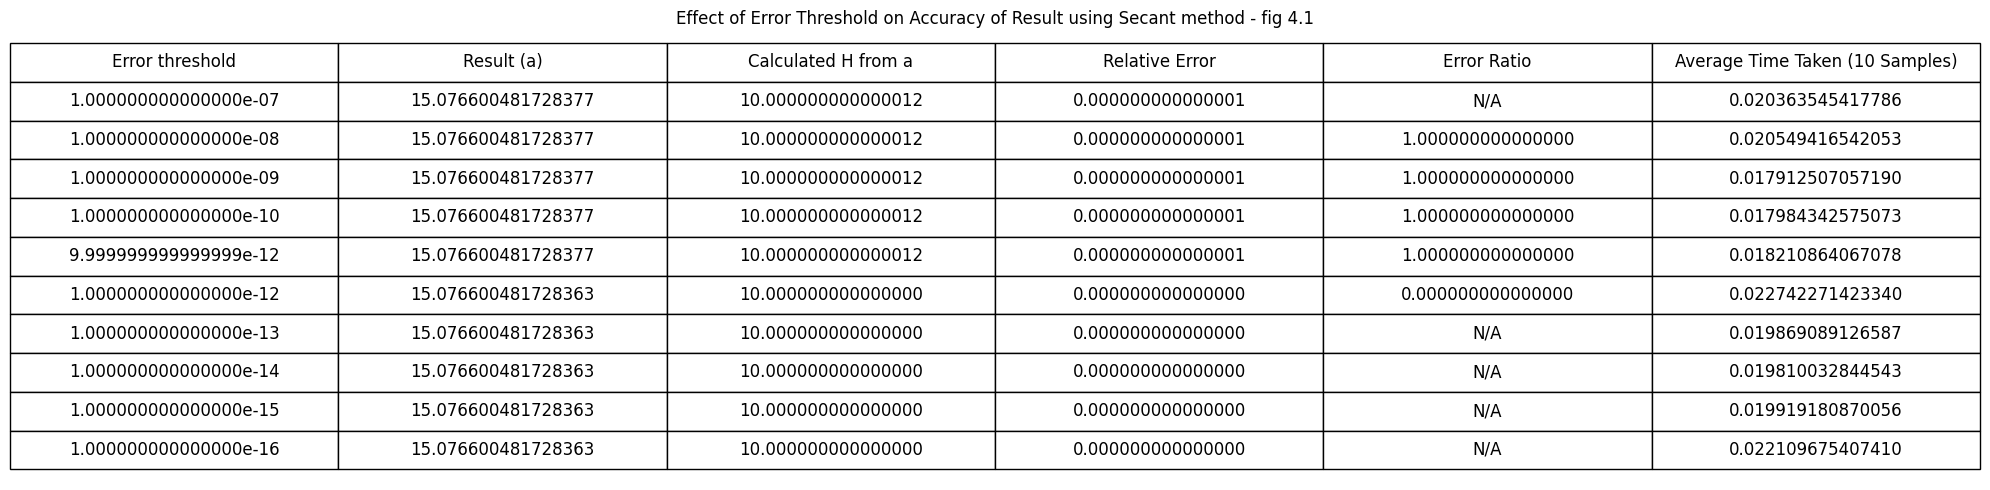

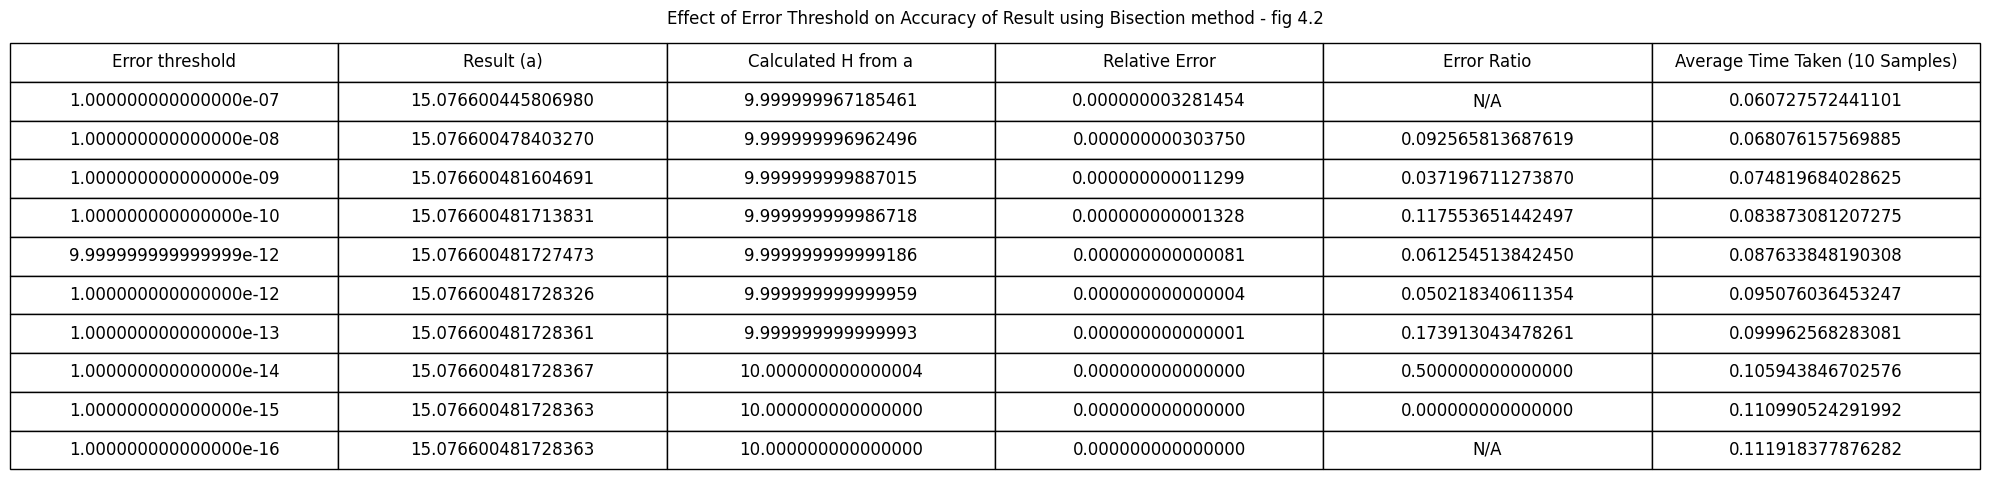

In [245]:
def create_table(error_set, method):
    """
    Outputs the values in the dataframe using plt table, for better data
    visualisation. Includes a line graph of time taken vs step size.

    Args:
        error_set (int array): values of error thresholds
        method (string): method for solver to use

    Returns:
        plt.Figure: table and line graph of results
    """

    # Initialises arrays to be added to dataframe
    results_array = []
    calculated_height_array = []
    relative_error_array = []
    time_taken_array = []
    
    for error in error_set:
        temp_array = []
        for i in range(0, 10):
            if method == "Secant":
                start = time.time()
                result = secant(k=0.05, g=9.81, m=1.3, y0=0, t0=0, dt=1.5/100, T=1.5, H=10, method="Van der Houwen", step=20, error_threshold=np.double(error))
                end = time.time()
                
            elif method == "Bisection":
                start = time.time()
                result = bisection(k=0.05, g=9.81, m=1.3, y0=0, t0=0, dt=1.5/100, T=1.5, H=10, method="Van der Houwen", step=5, tolerance=np.double(error))
                end = time.time()
            
            temp_array.append(end-start)
        
        # Caluclates the height at v0=a, to check if the calculated value of a is correct
        t,y = fireworkSolver(k=0.05, g=9.81, m=1.3, y0=0, v0=result, t0=0, dt=1.5/100, T=1.5, method="Van der Houwen")
        calculated_height = y[-1][0]
        
        results_array.append(result)
        calculated_height_array.append(calculated_height)  
        time_taken_array.append(sum(temp_array)/10)
        relative_error_array.append(abs(10 - calculated_height) / 10)
    

    # Creates a dataframe with the results for each error
    df = pd.DataFrame({
        "error threshold": error_set,
        "result": results_array,
        "calculated result": calculated_height_array,
        "relative error": relative_error_array,
        "time taken": time_taken_array
    })
    
    # Calculates error ratio between current and previous value.
    df["error_ratio"] = df["relative error"] / df["relative error"].shift()
    
    return df
    
    
def plot_results_non_linear_solver_error_thresholds(error_set, method, index=index):
    """
    Outputs the values in the dataframe using plt table, for better data
    visualisation.

    Args:
        method (string): method for solver to use
        dt_set (int array): values of dt

    Returns:
        plt.Figure: table of data
    """
    
    df = create_table(error_set, method)
    
    # Creates rows to add to the table
    row_data = []
    for i, row in df.iterrows():
        row_data.append([
            f'{row["error threshold"]:.15e}',
            f'{row["result"]:.15f}',
            f'{row["calculated result"]:.15f}',
            f'{row["relative error"]:.15f}',
            f'{row["error_ratio"]:.15f}' if not pd.isna(row["error_ratio"]) else 'N/A',
            f'{row["time taken"]:.15f}'
        ])
    
    plots, table_axes = plt.subplots(figsize=(20, 5)) 
    table_axes.axis("off")
    
    # Create the table
    table = table_axes.table(
        cellText=row_data,
        colLabels=["Error threshold", "Result (a)", "Calculated H from a", "Relative Error", "Error Ratio","Average Time Taken (10 Samples)"],
        loc="center",
        cellLoc="center"
    )
    
    # Increases from the default font size
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    
    # Scales table, and sets a title
    table.scale(1, 2)
    table_axes.set_title(f"Effect of Error Threshold on Accuracy of Result using {method} method - fig 4.{index}")

    
    plt.tight_layout()
    return plots  # Returning the figure with the table and graph


for index, method in enumerate(["Secant", "Bisection"]):
    plots = plot_results_non_linear_solver_error_thresholds(error_set=[1.0e-7,1.0e-8,1.0e-9,1.0e-10,1.0e-11,1.0e-12,1.0e-13,1.0e-14,1.0e-15,1.0e-16], method=method, index=index+1)
    plt.show()

As before, since average of 10 samples isn't enough, the discussion in the Analysis section is done based on results from 500 samples, that can be found in Appendix B. Also note that $1.0*10^{-11}$ shows as $9.9*10^{-12}$, due to floating point rounding errors.


We also want to test how many iterations each method uses - for this the secant and bisection functions, defined previously, have been edited to include an iteration counter, that ticks every time the while loops restart. The parameter set will be kept as before.

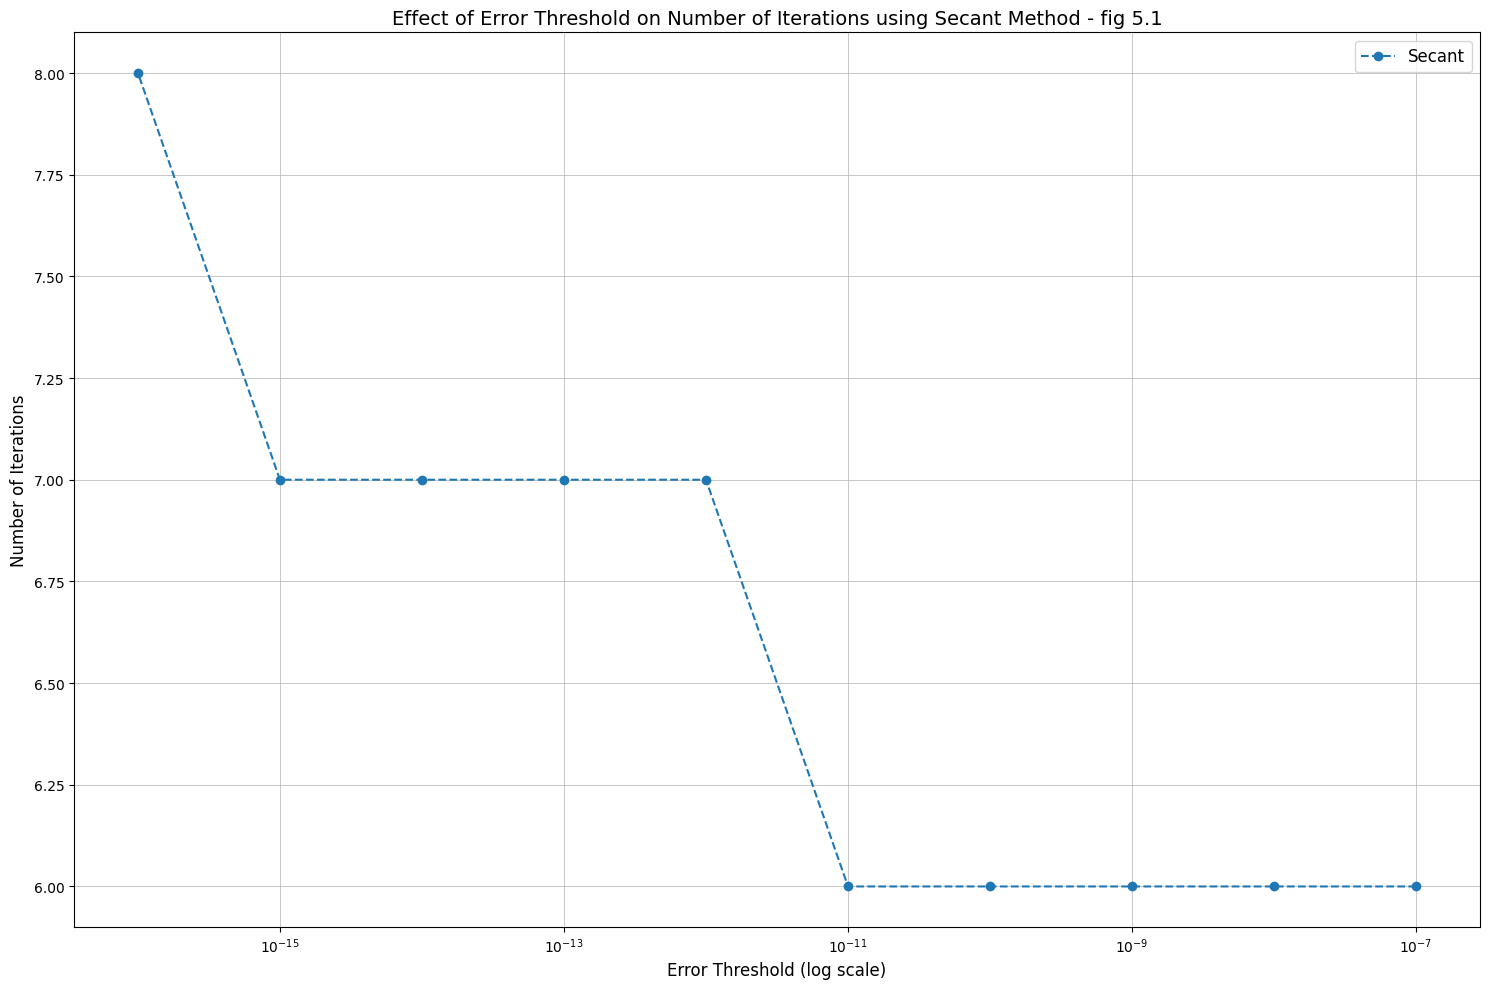

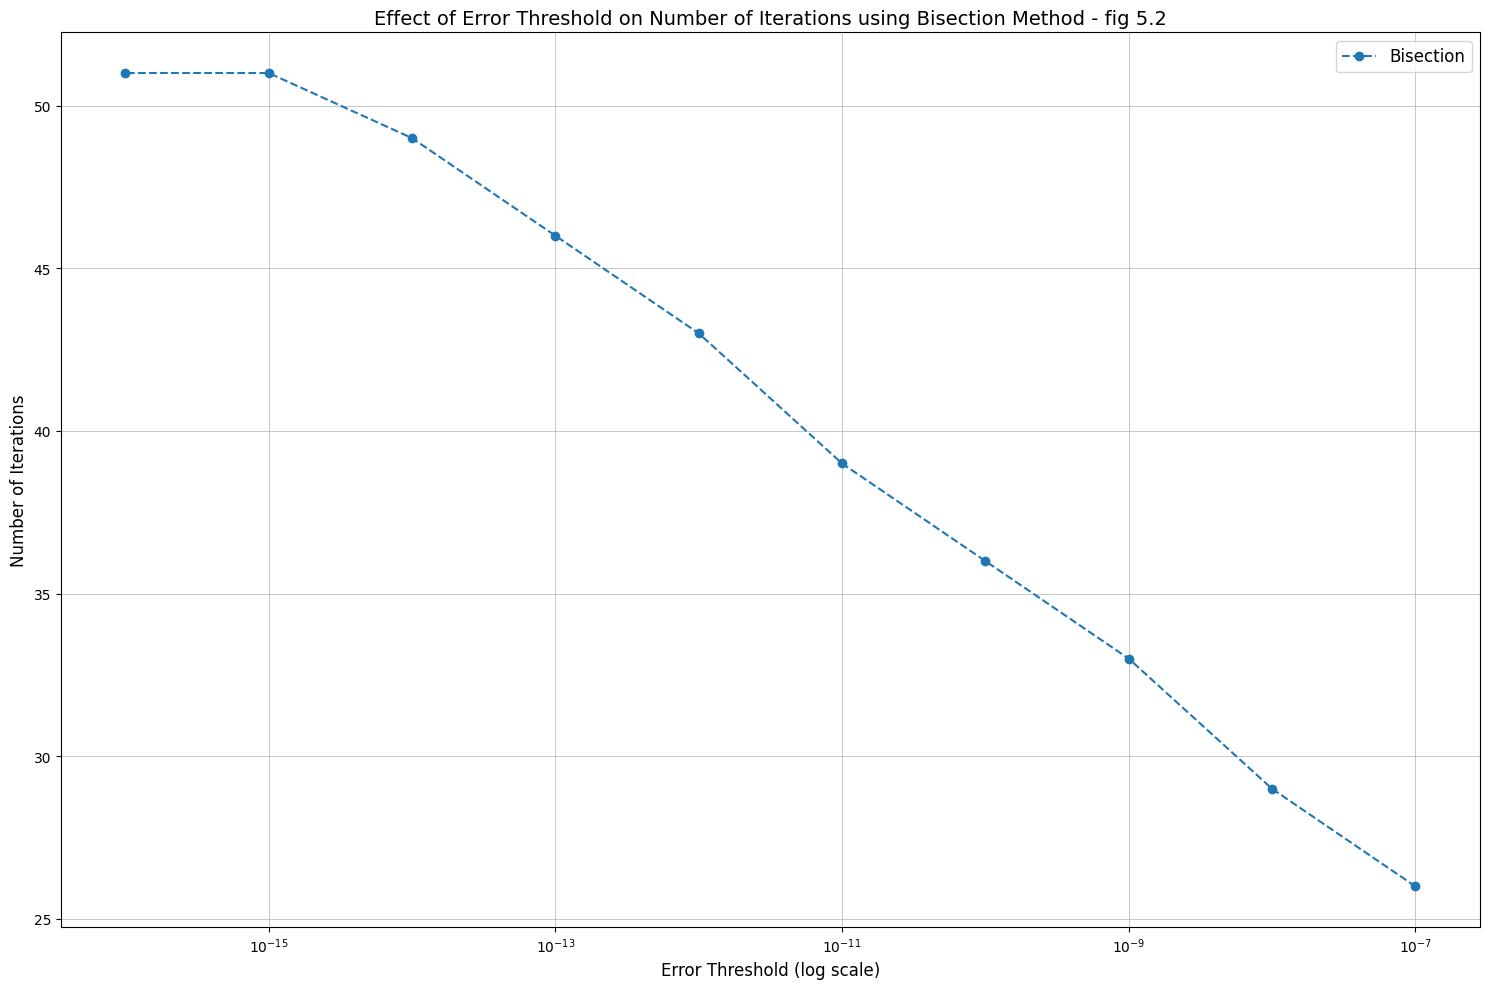

In [247]:
def secant_with_iteration_count(k: np.double, g: np.double, m: np.double, y0: np.double, t0: np.double, dt: np.double, T: np.double, H: np.double, method: str, step: np.double, error_threshold: np.double):
    a_p, a_c = find_starting_points(k=k, g=g, m=m, y0=y0, t0=t0, dt=dt, T=T, H=H, method=method, step=step)
    a_n = np.double(1)
    
    t,y = fireworkSolver(k=k, g=g, m=m, y0=y0, v0=a_c, t0=t0, dt=dt, T=T, method=method)
    y_a_c = y[-1][0] - H
    t, y = fireworkSolver(k=k, g=g, m=m, y0=y0, v0=a_p, t0=t0, dt=dt, T=T, method=method)
    y_a_p = y[-1][0] - H
    
    # Added iteration counter
    iterations = 0
    while True:
        iterations += 1
        a_n = a_c - (y_a_c * ((a_c - a_p)/(y_a_c - y_a_p)))
        
        relative_error = abs((a_n - a_c) / a_n)
        if relative_error < error_threshold:
            return iterations, a_n
        
        y_a_p = y_a_c
        a_p = a_c
        a_c = a_n
        
        t, y = fireworkSolver(k=k, g=g, m=m, y0=y0, v0=a_n, t0=t0, dt=dt, T=T, method=method)
        y_a_c = y[-1][0] - H
        

def bisection_with_iteration_count(k: np.double, g: np.double, m: np.double, y0: np.double, t0: np.double, dt: np.double, T: np.double, H: np.double, method: str, step: np.double, tolerance: np.double):    
    a1, a2 = find_starting_points(k=k, g=g, m=m, y0=y0, t0=t0, dt=dt, T=T, H=H, method=method, step=step)
    
    # Added iteration counter
    iterations = 0
    while True:
        iterations += 1
        a = np.double((a1 + a2) / 2)
        
        t, y_a = fireworkSolver(k=k, g=g, m=m, y0=y0, v0=a, t0=t0, dt=dt, T=T, method=method)
        y_a_at_T = y_a[-1][0] - H
        
        if y_a_at_T == 0:
            return iterations, a
        elif y_a_at_T < 0:
            a1 = a
        else:
            a2 = a
            
        if (a2 - a1) < tolerance:
            return iterations, (a1 + a2) / 2    
        
        
def plot_results_iterations(error_set, method, index):
    """
    Plots the number of iterations taken by the Secant and Bisection methods
    against the error thresholds.
    
    Args:
        error_set (list): Values of error thresholds.
        methods (list): Methods to compare ["Secant", "Bisection"].
    """
    iteration_counts = []
    for error in error_set:
        if method == "Secant":
            iterations, a = secant_with_iteration_count(k=0.05, g=9.81, m=1.3, y0=0, t0=0, dt=1.5/100, T=1.5, H=10, method="Van der Houwen", step=20, error_threshold=np.double(error))
        elif method == "Bisection":
            iterations, a = bisection_with_iteration_count(k=0.05, g=9.81, m=1.3, y0=0, t0=0, dt=1.5/100, T=1.5, H=10, method="Van der Houwen", step=5, tolerance=np.double(error))
        iteration_counts.append(iterations)

    # Plotting the results
    plt.figure(figsize=(15, 10))
    plt.plot(error_set, iteration_counts, label=method, marker='o', linestyle="--")
    
    plt.xscale("log")
    plt.xlabel("Error Threshold (log scale)", fontsize=12)
    plt.ylabel("Number of Iterations", fontsize=12)
    plt.title(f"Effect of Error Threshold on Number of Iterations using {method} Method - fig 5.{index}", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(visible=True, which="both", linewidth=0.5)
    plt.tight_layout()

for index, method in enumerate(["Secant", "Bisection"]):
    plots = plot_results_iterations(error_set=[1.0e-7,1.0e-8,1.0e-9,1.0e-10,1.0e-11,1.0e-12,1.0e-13,1.0e-14,1.0e-15,1.0e-16], method=method, index=index+1)
    plt.show()


## Analysis

###  Solving Differential Equations
#### Initial Trajectory Plot - Fig 1.1-3
These plots seem reasonable, with the displacement increasing until a maximum point, and the velocity decreasing until it reaches 0 m/s, at the y-max. All methods output extremely similar graphs.

#### Comparison of Internal Solver Methods - Fig 2.1-3
These results allows us to compare the accuracy and speed of each of the different methods. Looking at the relative errors for each of the methods we can see that for Van der Houwen and Classic Runge-Kutta, tend to plateau at around $2.5 * 10^{-8}$ for larger values of $dt$, with Runge Kutta stabilising for $dt>150$ and Van der Houwen for $dt>800$, shown by their corresponding error ratios approaching $1$. The Ralston method has a much greater variation in relative errors and doesn't seem to stabilise for any $dt$, shown by the varying error ratios. As expected, the 2nd order, Ralston method computes a value for the differential equation the fastest, with the 3rd order, Vander Houwen and 4th order, Classic Runge-Kutta method, increasing in time taken. The reading with the lowest relative error was found using the Van der Houwen method for $dt=100$, at a relative error of $6.2*10^{-9}$. 

### Solving Non-Linear Equation using Secant and Bisection Method
#### Calculating Optimal Step Size - Fig 3.1-2
For both the secant and bisection method, we can see that having a low step size results in a much longer computation time - the function, find_starting_points(), that calculates the initial values makes use of the differential solver too, hence it is also a computationally expensive function. Increasing the step size reduces the number of iterations required to find initial values, but increases the number of iterations of the bisection/secant method required to solve the non-linear equation. Thus, the optimal step size for the secant method is $20$ and for the bisection method, it is $5$, as it results in the smallest average time taken to compute a solution for $F(a) = 0$. An alternative approach would be to use hard-coded initial values, but then we would get a problem where neither the bisection or secant method would work for certain input parameters, as the hard-coded values may not contain the root within it. We could make the range extremely large, which would work for all parameter sets we would realistically use with the differential equation, but the range would be too large, and the time saved in not having to compute the initial values will be less than the extra time taken to compute further iterations of bisection/secant method.

#### Calculating Optimal Error Thresholds and Result Comparison - Fig 4.1-2, 5.1-2
These results show that both methods eventually converge and find a solution for $F(a)$ correct to at least 15 decimal places, with the secant methods stabilising for $\varepsilon<1.0*10^{-12}$ and the bisection method stabilising for $\varepsilon<1.0*10^{-15}$, where $\varepsilon$ is the error threshold. However, the secant method does this almost 5 times faster, and converges much earlier at a smaller threshold. The threshold has a very minimal effect of the time it takes for the secant method to converge, while for the bisection method, the time taken almost doubles from $0.06s$ to $0.11s$. The number of iterations of the bisection method increases, as the error threshold decreases, which explains why its computation time also increases. For the secant method, the number of iterations increases after the error thresholds decreases by a certain amount - thus an optimal value for $\varepsilon_{secant}$ would be $1.0*10^{-15}\leq\varepsilon_{secant}\leq1.0*10^{-12}$, as going any lower would increase the number of iterations required, and would be lower than the machine epsilon value of $2.2*10^{-16}$, which may sometimes result in division by 0 errors. Therefore, $\varepsilon_{secant}=1.0*10^{-15}$, as using the smallest value in the optimal range, will give the most accurate result for an abritrary equation. For bisection method, the optimal value is $\varepsilon=1.0*10^{-15}$, as it the first value where the error ratio is 0 - we are not using $\varepsilon=1.0*10^{-16}$ as computation time increases as error threshold increases, and since the bisection method is quite slow, cutting down on processing time is especially important here.



## Conclusion

Based on the results in Fig 2.1-3, the Van der Houwen method, when $dt=100$ appears to be the most suited for this specific set of differential equations. It performs better than the Runge-Kutta method in terms of both size of relative error and computation speed, and while it is not as fast as the Ralston method, the significantly decreased relative error makes it a better option for calculating the trajectory of a firework. Thus, the Van der Houwen method has been used to solve the differentials when calculating for $F(a)$. Between the bisection and secant method, the secant method is clearly more efficient. It converges much faster - at $\varepsilon=1.0*10^{-7}$, it is accurate to 13 decimal places while the result from the bisection method is accurate to only 7 decimal places - while having a shorter computation time. The optimal step size and error threshold values acquired from the results should also be used as it is the best balance of accuracy and computational speed to solve this specific problem.

It is recommended to use the following function calls when solving differential equations, and non-linear equations:

```python
fireworkSolver(k: np.double, g: np.double, m: np.double, y0: np.double, v0: np.double, t0: np.double, dt: np.double = T/100, T: np.double, method: str = "Van der Houwen")
secant(k: np.double, g: np.double, m: np.double, y0: np.double, t0: np.double, dt: np.double = T/100, T: np.double, H: np.double, method: str = "Van der Houwen", step: np.double = 20, error_threshold: np.double = 1.0e-16):

```

## Appendix

A: \
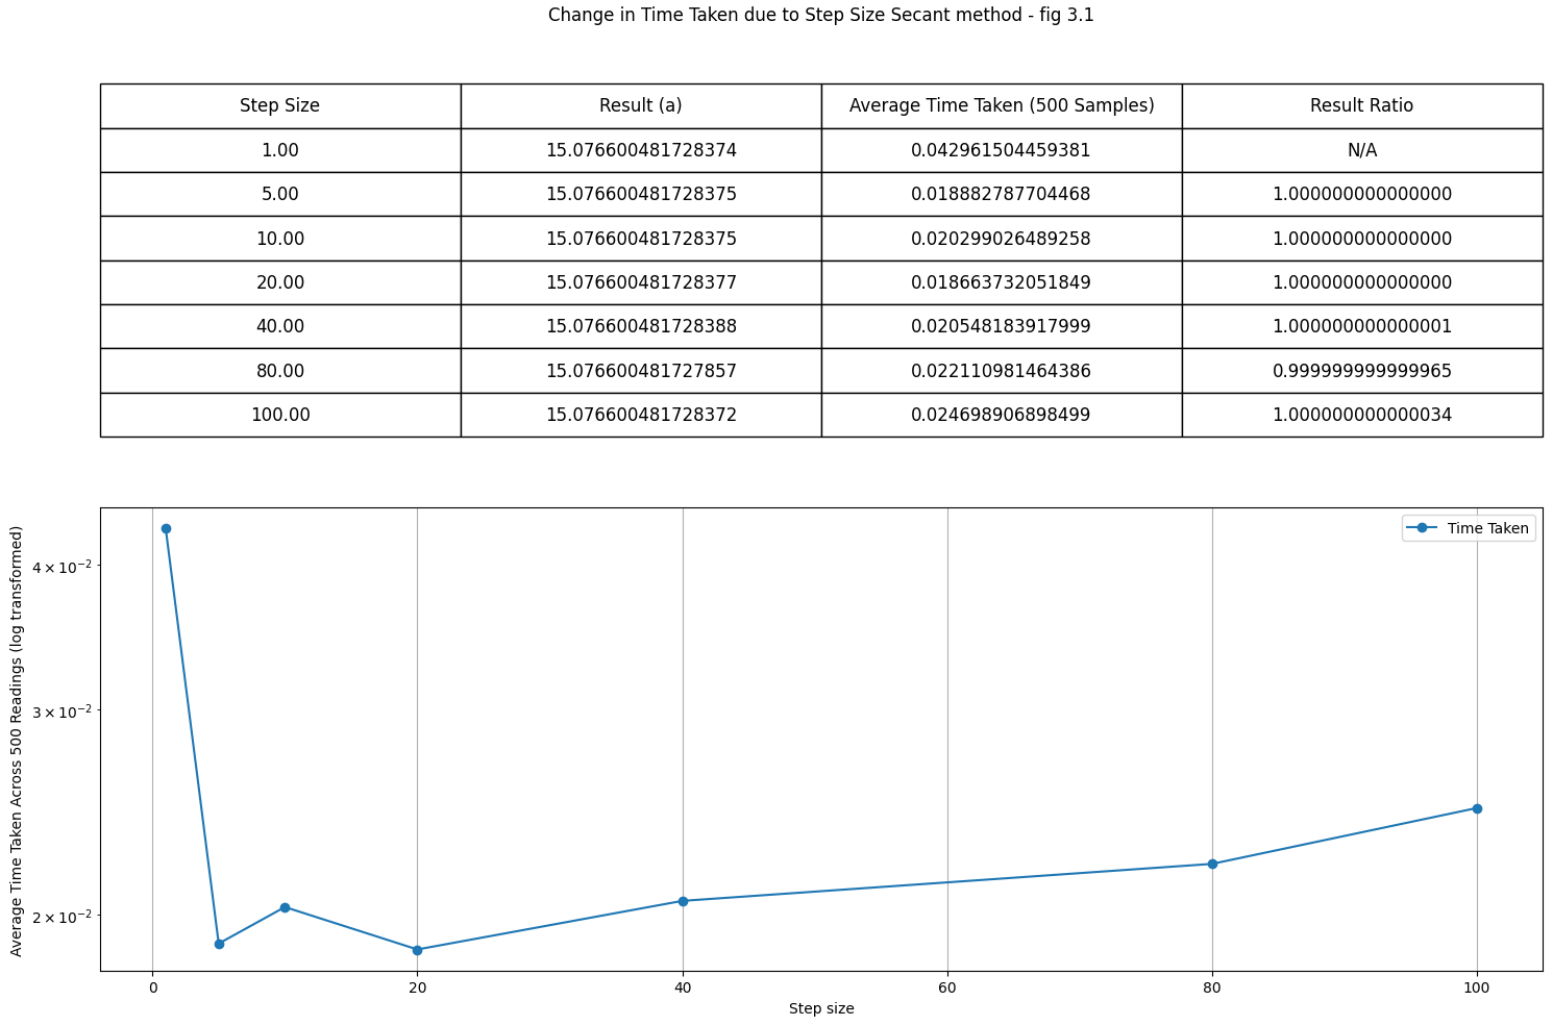
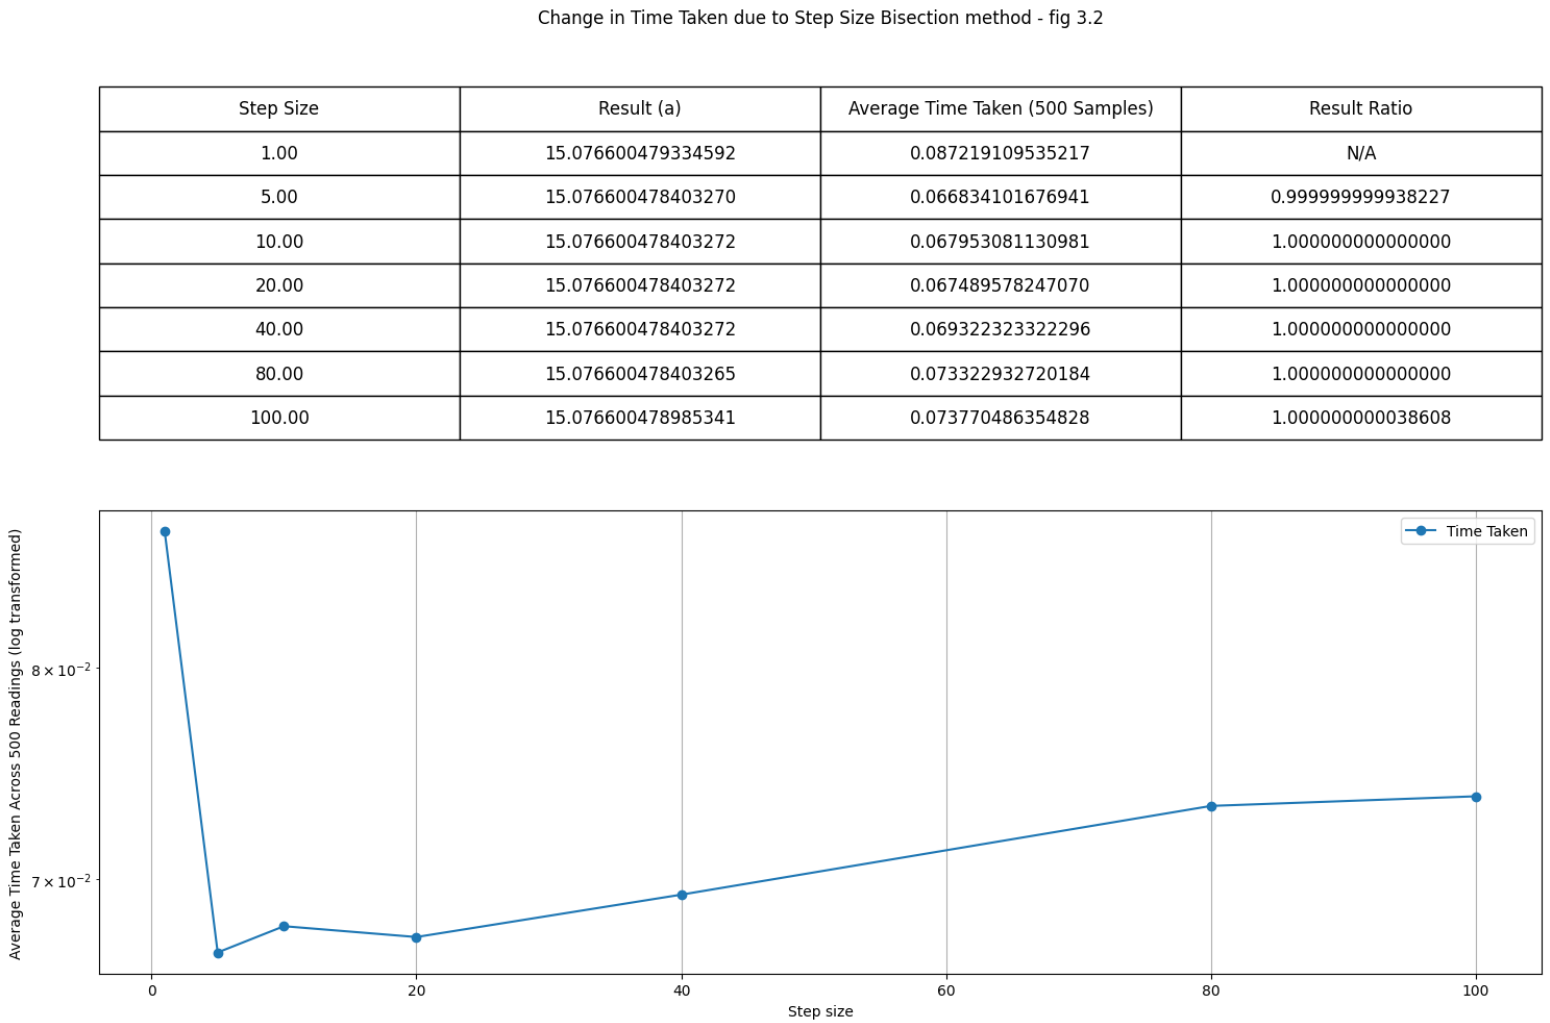
\
B: \
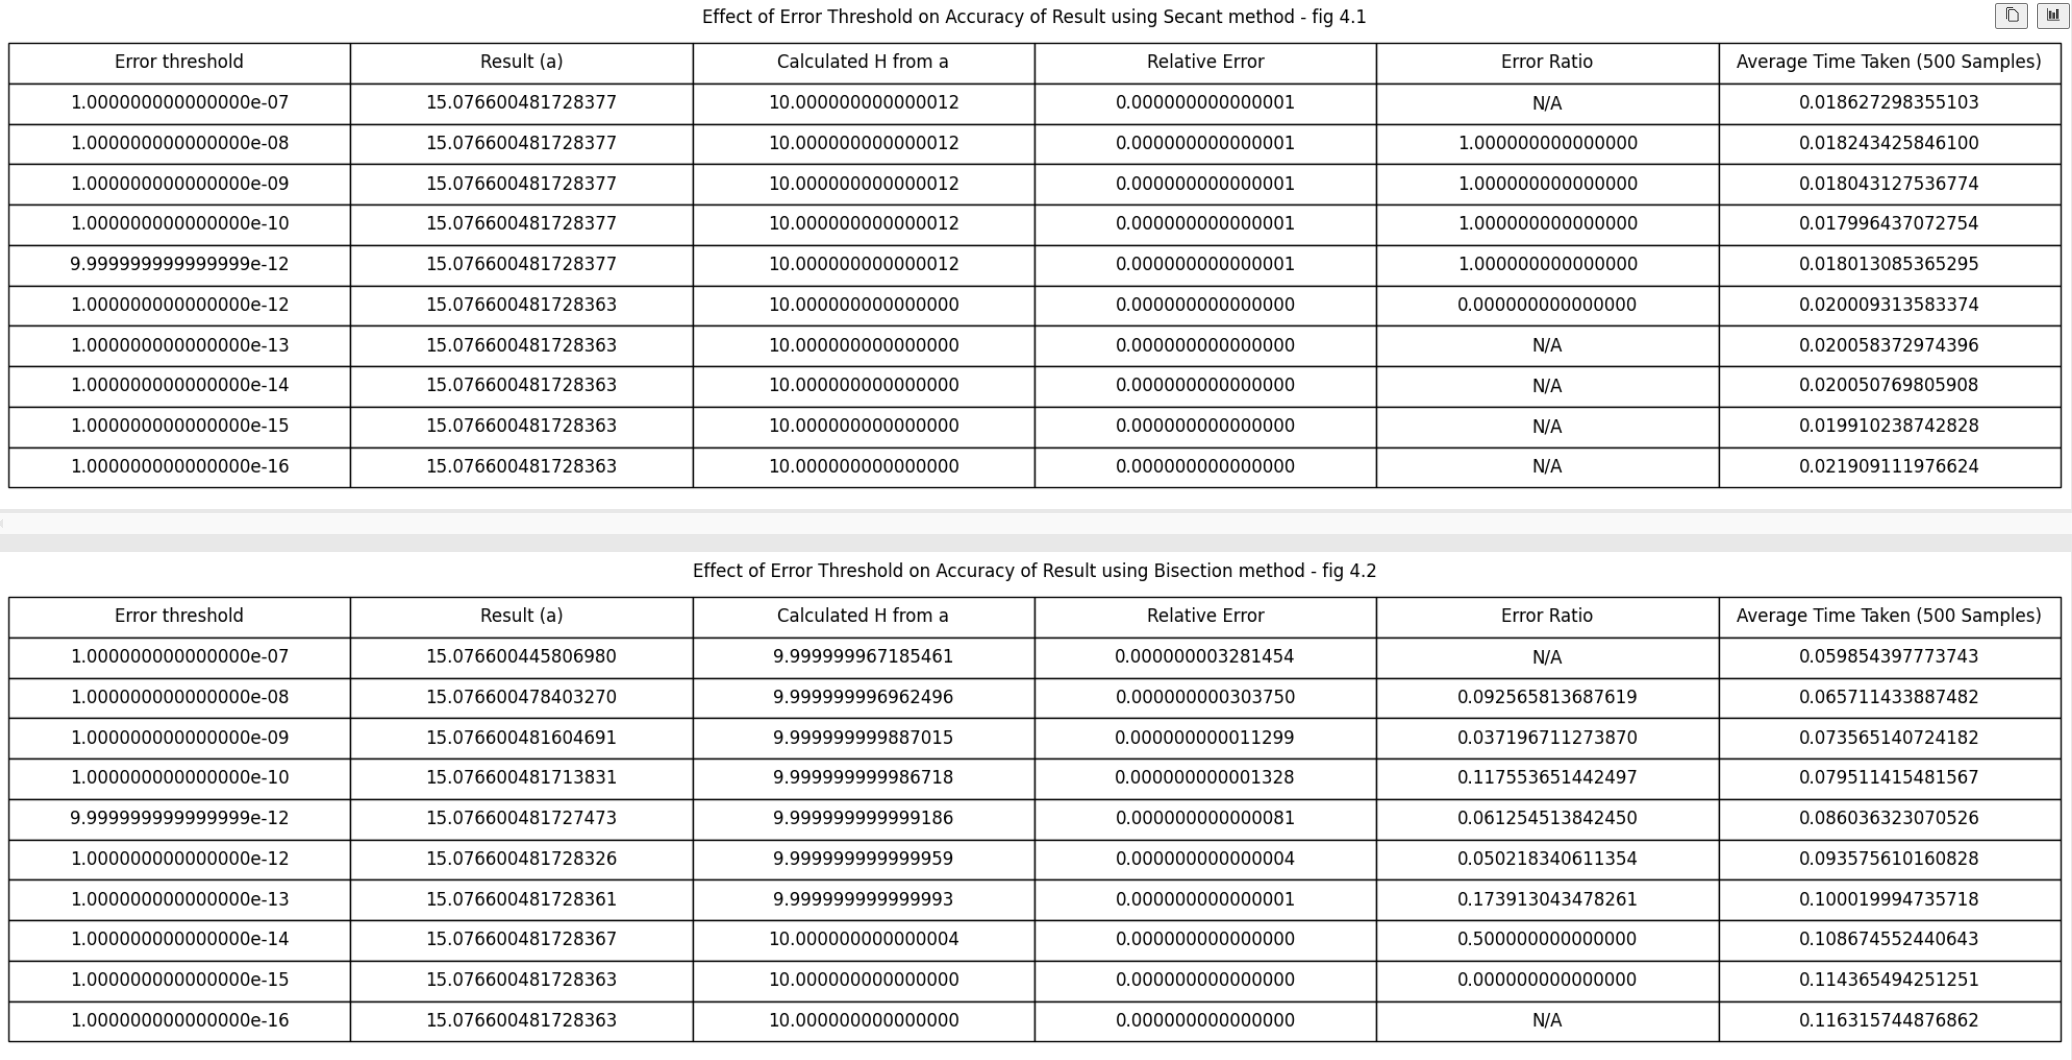